In [50]:
# Cell 1: Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit‑learn imports
# splits the data into train/test
# does the cross-validation that preserves classes ratios
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Displays settings
%matplotlib inline


In [52]:
# Cell 2: Load the NBA All-Star dataset and shows first five rows
data = pd.read_csv('nba_all_star_stats.csv')
data.head()


,first,last,team,year,games_played,min,fgm,fga,fg3m,fg3a,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
0,Julius,Erving,PHI,1980,82.0,35:02:00,9.68,18.59,0.05,0.22,...,8.01,4.44,2.62,1.73,3.40,2.84,24.56,0.521,0.220,0.787
1,Eddie,Johnson,ATL,1980,75.0,35:55:00,7.64,15.16,0.08,0.32,...,2.39,5.47,1.54,0.11,2.70,2.53,19.08,0.504,0.249,0.784
2,Artis,Gilmore,CHI,1980,81.0,34:31:00,6.67,9.93,0.00,0.00,...,10.06,2.15,0.77,2.43,3.31,3.58,17.89,0.672,0.000,0.706
3,Reggie,Theus,CHI,1980,81.0,34:20:00,6.58,13.38,0.22,1.09,...,3.56,5.41,1.73,0.28,3.65,3.14,18.84,0.492,0.203,0.808
4,Larry,Bird,BOS,1980,82.0,39:30:00,8.77,18.33,0.24,0.92,...,10.91,5.50,2.61,0.84,3.69,2.91,21.23,0.478,0.266,0.863


In [54]:
# Cell 3: Inspects and clean, converts the ‘min’ to numeric then creates target

import numpy as np

# 1) See your columns
print("Columns:", data.columns.tolist())

# 2) Convert 'min' strings like "34:31:00" to float minutes
def parse_minutes(x):
    try:
        parts = str(x).split(':')
        if len(parts) == 3:           # "HH:MM:SS"
            h, m, s = parts
            return int(h)*60 + int(m) + int(s)/60
        elif len(parts) == 2:         # "MM:SS"
            m, s = parts
            return int(m) + int(s)/60
        else:                         
            return float(x)
    except:
        return np.nan

data['min'] = data['min'].apply(parse_minutes)

# 3) Identifies numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

# 4) Drops the rows missing our PPG source 'pts'
data = data.dropna(subset=['pts'])

# 5) Fills the missing values only in numeric columns
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].mean())

# 6) Build binary target 'high_scorer' (1 if pts ≥ median, else 0)
threshold = data['pts'].median()
data['high_scorer'] = (data['pts'] >= threshold).astype(int)


# shows how many players are in each class
print(f"\nMedian pts = {threshold:.2f}")
print("high_scorer counts:\n", data['high_scorer'].value_counts())


Columns: ['first', 'last', 'team', 'year', 'games_played', 'min', 'fgm', 'fga', 'fg3m', 'fg3a', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'turnover', 'pf', 'pts', 'fg_pct', 'fg3_pct', 'ft_pct']
Numeric columns: ['year', 'games_played', 'min', 'fgm', 'fga', 'fg3m', 'fg3a', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'turnover', 'pf', 'pts', 'fg_pct', 'fg3_pct', 'ft_pct']

Median pts = 21.36
high_scorer counts:
 high_scorer
1    501
0    501
Name: count, dtype: int64


In [56]:
# Cell 4: Selects features & standardize

from sklearn.preprocessing import StandardScaler

# pick at least five numeric stats
features = [
    'min',      # now is numeric minutes
    'ast',
    'reb',
    'stl',
    'blk',
    'turnover',
    'fg_pct',
    'fg3_pct',
    'ft_pct'
]

X = data[features]
y = data['high_scorer']

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# quick  check
import numpy as np
print("X_scaled shape:", X_scaled.shape)
print("Target distribution:", np.bincount(y))


X_scaled shape: (1002, 9)
Target distribution: [501 501]


In [58]:
# Cell 5: 5‑fold CV AUROC for two models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# defines our 2 models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}
# Runs the CV for each and reports mean+- std of AUROC
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    print(f"{name} CV AUROC: {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression CV AUROC: 0.814 ± 0.015
Random Forest CV AUROC: 0.859 ± 0.019


In [59]:
# Cell 6: Feature importance from Random Forest and Logistic Regression
# which stats are most influential
# 6a. Random Forest importances
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_scaled, y)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("Top 5 RF features:\n", importances.head(5))

# 6b. Logistic Regression coefficients (absolute value)
lr = LogisticRegression(max_iter=1000).fit(X_scaled, y)
coefs = pd.Series(np.abs(lr.coef_[0]), index=features).sort_values(ascending=False)
print("\nTop 5 LR features:\n", coefs.head(5))


Top 5 RF features:
 turnover    0.157525
min         0.152770
ast         0.129232
reb         0.114298
ft_pct      0.109114
dtype: float64

Top 5 LR features:
 turnover    1.215974
ast         0.850016
min         0.806482
ft_pct      0.774863
fg3_pct     0.416309
dtype: float64


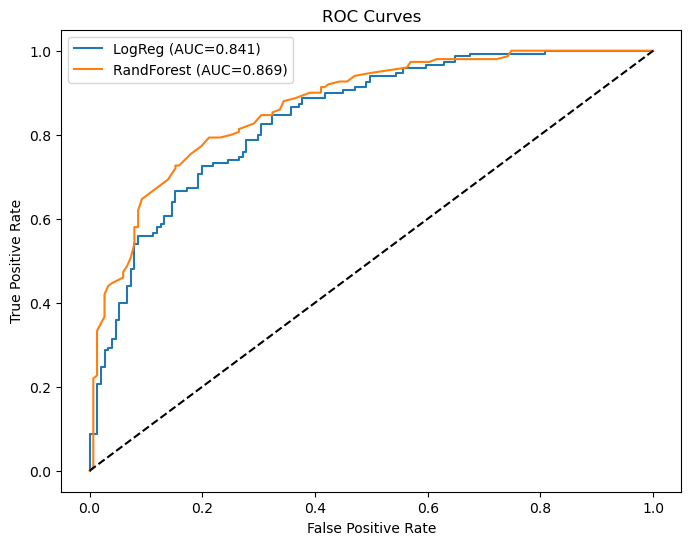

In [60]:
# Cell 7: Plots the ROC curves for both models
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# Trains the models
lr.fit(X_tr, y_tr)
rf.fit(X_tr, y_tr)

# Gets the prediction probabilities
y_prob_lr = lr.predict_proba(X_te)[:,1]
y_prob_rf = rf.predict_proba(X_te)[:,1]

# Computes the ROC data
fpr_lr, tpr_lr, _ = roc_curve(y_te, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_te, y_prob_rf)

# Plot both curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc(fpr_lr,tpr_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandForest (AUC={auc(fpr_rf,tpr_rf):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


In [61]:
## Ethical Considerations

#Dataset Bias: Fan voting and media hype influence All-Star selections
#Historical Inequities: Past biases (example like market size, race) may be encoded in the data.
